# Developing and Evaluating Intrusion Detection Systems (IDS)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.models import Model
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, SparkTrials, space_eval
from hyperopt.early_stop import no_progress_loss
import mlflow
from mlflow.models.signature import infer_signature

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(mlflow.__version__)
print(tf.__version__)

# MLflow configuration
mlflow.tensorflow.autolog()


2.11.0
2.15.0


## Load and preprocess the dataset


In [0]:
# Load and preprocess the dataset
def load_preprocess_dataset(path):
    # Load the dataset
    df = pd.read_csv(path, index_col=0).reset_index()
    df = df.dropna()

    # Separate features and labels
    X_scaled = df.drop('Attack_type', axis=1)
    y = df['Attack_type']

    # Encode labels as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return X_scaled, y_encoded, label_encoder.classes_


## Load dataset

In [0]:
# Load dataset 
processed_file_path = '/dbfs/FileStore/m332479/GANs_forCyberSecurity/processed_RT_IOT2022.csv'
X, y, classes = load_preprocess_dataset(processed_file_path)
num_classes, num_features = len(classes), X.shape[1]
num_classes, num_features

(10, 40)

## Split Dataset

In [0]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Initialize MLFlow Experments

In [0]:
# COMMAND ----------
mlflow.end_run()
# Initializes an MLflow experiment for tracking machine learning tasks. 
# It checks if the specified experiment already exists and creates it if not, storing the experiment ID.
dbutils.widgets.text("mlflow_exp_root_path","/Users/m332479@azg.pwus.us/ml_experments")

from mlflow.tracking import MlflowClient
mlflow_exp_root_path = dbutils.widgets.get("mlflow_exp_root_path")
client = MlflowClient()

## Test if experiment already exists
exp_name = f"{mlflow_exp_root_path}/cGAN_study04"
if exp_name in [x.name for x in client.search_experiments()]:
    exp = mlflow.set_experiment(exp_name)
    experiment_id = exp.experiment_id
else:
    ## Create an experiment for runs started from a repo notebook
    experiment_id = client.create_experiment(f"{mlflow_exp_root_path}/cGAN_study04")
experiment_id


'4386090023969667'

In [0]:
study = '02'

run_name = f'hyperopt_cGAN{study}'
exp_id = experiment_id

## cGAN Generator and Discriminator Models

In [0]:
# Define the generator and discriminator models
def build_generator(latent_dim, num_classes, num_features):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, latent_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(128)(model_input)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)   # Adjusted alpha
    x = layers.BatchNormalization(momentum=0.8)(x)  # Adjusted momentum
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(256)(model_input)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)   # Adjusted alpha
    x = layers.BatchNormalization(momentum=0.8)(x)  # Adjusted momentum
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(512)(x)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)  # Adjusted alpha
    x = layers.BatchNormalization(momentum=0.8)(x)  # Adjusted momentum
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(1024)(x)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)  # Adjusted alpha
    x = layers.BatchNormalization(momentum=0.8)(x)  # Adjusted momentum
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(num_features, activation='tanh')(x)

    model = models.Model([noise, label], x)
    return model


def build_discriminator(num_classes, num_features):
    data = layers.Input(shape=(num_features,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(num_classes, num_features)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([data, label_embedding])

    x = layers.Dense(512)(model_input)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(256)(x)  # Increased capacity
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(128)(x)  
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.4)(x)  # Adjusted dropout rate

    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([data, label], x)
    # During training, use label smoothing for the discriminator's targets
    return model




## cGAN Model Objective and Training 

In [0]:
# cGAN Model Objective and Training function
EPOCHS = 1000
def train_model(params, X_train, X_test, y_train, y_test, num_classes, num_features, EPOCHS, log_interval):
    batch_size = params['batch_size']
    latent_dim = params['latent_dim']
    optimizer_g = tf.keras.optimizers.Adam(learning_rate=params['learning_rate_generator'], beta_1=params['beta_1'])
    optimizer_d = tf.keras.optimizers.Adam(learning_rate=params['learning_rate_discriminator'], beta_1=params['beta_1'])

    discriminator = build_discriminator(num_classes, num_features)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])

    generator = build_generator(latent_dim, num_classes, num_features)
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    generated_data = generator([noise_input, label_input])
    discriminator.trainable = False
    validity = discriminator([generated_data, label_input])
    combined_model = models.Model([noise_input, label_input], validity)
    combined_model.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    d_losses, g_losses, d_test_losses = [], [], []
    print(f"Starting training for {EPOCHS} epochs.")
    for epoch in range(1, EPOCHS+1):
        # Training discriminator with real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train.iloc[idx].values
        real_labels = y_train[idx]
        d_loss_real = discriminator.train_on_batch([real_data, real_labels], np.ones((batch_size, 1)))
    

        # Training discriminator with fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        fake_data = generator.predict([noise, fake_labels])
        d_loss_fake = discriminator.train_on_batch([fake_data, fake_labels], np.zeros((batch_size, 1)))
   
        # Discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)  # Labels for generated data
        g_loss = combined_model.train_on_batch([noise, fake_labels], np.ones((batch_size, 1)))

        # Logging the progress
        if epoch % log_interval == 0:
            
            # Calculate test loss for discriminator
            test_loss_real = discriminator.evaluate([X_test, np.ones((X_test.shape[0], 1))], np.ones((X_test.shape[0], 1)), verbose=0)
            
            # Generate fake data for testing
            noise_test = np.random.normal(0, 1, (X_test.shape[0], latent_dim))
            fake_labels_test = np.random.randint(0, num_classes, X_test.shape[0])  # These labels are not used for evaluating the discriminator
            fake_data = generator.predict([noise_test, fake_labels_test])

            # Evaluate discriminator on fake test data
            test_loss_fake = discriminator.evaluate([fake_data, np.zeros((fake_data.shape[0], 1))], np.zeros((fake_data.shape[0], 1)), verbose=0)
            
            # Calculate the average test loss for the discriminator
            d_test_loss = 0.5 * np.add(test_loss_real[0], test_loss_fake[0])

            # Append the losses for logging and visualization
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            d_test_losses.append(d_test_loss)
           
            print(f'Epoch {epoch}/{EPOCHS}')
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}] [D test loss: {d_test_loss}]")
            mlflow.log_metric("Discriminator Loss", d_loss[0], step=epoch)
            mlflow.log_metric("Generator Loss", g_loss, step=epoch)
            mlflow.log_metric("Discriminator Test Loss", d_test_loss, step=epoch)

        return {
            'loss': g_loss, 
            'status': STATUS_OK,
            'models': {
                'generator': generator,
                'discriminator': discriminator
            },
            'metrics': {
                'd_losses': d_losses,
                'g_losses': g_losses,
                'd_test_losses': d_test_losses
            }
        }


## Hyperopt search space

In [0]:
# Hyperopt search space
space = {
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'learning_rate_discriminator': hp.choice('learning_rate_discriminator', [1e-5, 1e-4, 1e-3, 1e-2]),
    'learning_rate_generator': hp.choice('learning_rate_generator', [1e-5, 1e-4, 1e-3, 1e-2]),
    'latent_dim': hp.choice('latent_dim', [100, 200, 500]),
    'beta_1': hp.choice('beta_1',[0.1, 0.2, 0.4, 0.6, 0.9])  # Typically between 0.0 and 0.9
}

In [0]:
# Initialize
mlflow.end_run()
mlflow.start_run()
mlflow.log_param("epochs", EPOCHS)

1000

## Hyperopt Optimization Best Model

In [0]:
# Run the optimization
MAX_EVALS = 50
log_interval = 100 
#trials = Trials()
trials = SparkTrials(parallelism=20)
mlflow.end_run()
with mlflow.start_run(run_name=run_name) as run: 
    print('optimization starting')
    best = fmin(
        fn=lambda params: train_model(params, X_train, X_test, y_train, y_test, num_classes, num_features, EPOCHS=1000, log_interval=log_interval),
        space=space,
        algo=tpe.suggest,
        max_evals=MAX_EVALS,  # Reduced for faster execution, adjust as needed
        trials=trials,
        max_queue_len=15,
        verbose=0
    )

print("Best: ", best)
# After running fmin, use space_eval to get the actual values of hyperparameters
best_params = space_eval(space, best)
print("Best parameters:", best_params)

optimization starting


Total Trials: 50: 50 succeeded, 0 failed, 0 cancelled.
INFO:hyperopt-spark:Total Trials: 50: 50 succeeded, 0 failed, 0 cancelled.


Best:  {'batch_size': 2, 'beta_1': 4, 'latent_dim': 1, 'learning_rate_discriminator': 2, 'learning_rate_generator': 1}
Best parameters: {'batch_size': 64, 'beta_1': 0.9, 'latent_dim': 200, 'learning_rate_discriminator': 0.001, 'learning_rate_generator': 0.0001}


In [0]:
best_params

{'batch_size': 64,
 'beta_1': 0.9,
 'latent_dim': 200,
 'learning_rate_discriminator': 0.001,
 'learning_rate_generator': 0.0001}

Starting training for 1000 epochs.
769/769 [==============================] - 3s 3ms/step
Epoch 1/1000
1 [D loss: 0.7749661803245544] [G loss: 0.7075170278549194] [D test loss: 0.6933415532112122]
769/769 [==============================] - 3s 3ms/step
Epoch 2/1000
2 [D loss: 0.7206597030162811] [G loss: 0.6681568026542664] [D test loss: 0.6930283606052399]
769/769 [==============================] - 3s 3ms/step
Epoch 3/1000
3 [D loss: 0.7020514011383057] [G loss: 0.6613933444023132] [D test loss: 0.6928119957447052]
769/769 [==============================] - 3s 3ms/step
Epoch 4/1000
4 [D loss: 0.6979286670684814] [G loss: 0.657660722732544] [D test loss: 0.6917285323143005]
1/1 [==============================] - 0s 27ms/step
499/769 [==================>...

*** WARNING: max output size exceeded, skipping output. ***

769/769 [==============================] - 3s 4ms/step
Epoch 996/1000
996 [D loss: 2.2405213168971667e-37] [G loss: 8313.681640625] [D test loss: 233.59017931111157]
769/76

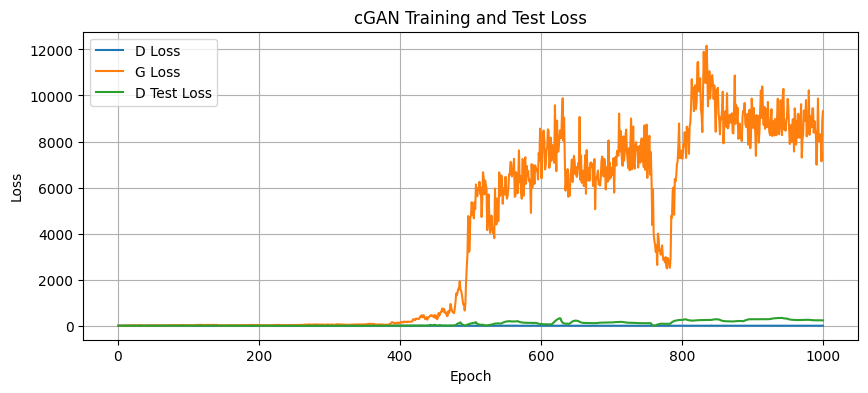

In [0]:
# cGAN Model Objective and Training function
EPOCHS = 1000
log_interval = 1
#def train_model(params, X_train, X_test, y_train, y_test, num_classes, num_features, EPOCHS, log_interval):
batch_size = 32
latent_dim = 100
# Start an MLflow run
with mlflow.start_run(run_name=f'Best_model_training_cGAN') as run:
    optimizer_g = tf.keras.optimizers.Adam(learning_rate=1e-05, beta_1=0.9)
    optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9)

    discriminator = build_discriminator(num_classes, num_features)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])

    generator = build_generator(latent_dim, num_classes, num_features)
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(1,))
    generated_data = generator([noise_input, label_input])
    discriminator.trainable = False
    validity = discriminator([generated_data, label_input])
    combined_model = models.Model([noise_input, label_input], validity)
    combined_model.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    d_losses, g_losses, d_test_losses = [], [], []
    print(f"Starting training for {EPOCHS} epochs.")
    for epoch in range(1, EPOCHS+1):
        # Training discriminator with real data
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train.iloc[idx].values
        real_labels = y_train[idx]
        d_loss_real = discriminator.train_on_batch([real_data, real_labels], np.ones((batch_size, 1)))
    
        # Training discriminator with fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size)
        fake_data = generator.predict([noise, fake_labels])
        d_loss_fake = discriminator.train_on_batch([fake_data, fake_labels], np.zeros((batch_size, 1)))
   
        # Discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)  # Labels for generated data
        g_loss = combined_model.train_on_batch([noise, fake_labels], np.ones((batch_size, 1)))

        # Logging the progress
        if epoch % log_interval == 0:
            
            # Calculate test loss for discriminator
            test_loss_real = discriminator.evaluate([X_test, np.ones((X_test.shape[0], 1))], np.ones((X_test.shape[0], 1)), verbose=0)
            
            # Generate fake data for testing
            noise_test = np.random.normal(0, 1, (X_test.shape[0], latent_dim))
            fake_labels_test = np.random.randint(0, num_classes, X_test.shape[0])  # These labels are not used for evaluating the discriminator
            fake_data = generator.predict([noise_test, fake_labels_test])

            # Evaluate discriminator on fake test data
            test_loss_fake = discriminator.evaluate([fake_data, np.zeros((fake_data.shape[0], 1))], np.zeros((fake_data.shape[0], 1)), verbose=0)
            
            # Calculate the average test loss for the discriminator
            d_test_loss = 0.5 * np.add(test_loss_real[0], test_loss_fake[0])

            # Append the losses for logging and visualization
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            d_test_losses.append(d_test_loss)
           
            print(f'Epoch {epoch}/{EPOCHS}')
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}] [D test loss: {d_test_loss}]")
            mlflow.log_metric("Discriminator Loss", d_loss[0], step=epoch)
            mlflow.log_metric("Generator Loss", g_loss, step=epoch)
            mlflow.log_metric("Discriminator Test Loss", d_test_loss, step=epoch)

    # Ensure you have a list of epochs to match the length of the loss lists
    epochs = list(range(1, EPOCHS + 1))

    # Create a dictionary for constructing the DataFrame
    loss_data = {
        'Epochs': epochs,
        'D Loss': d_losses,
        'G Loss': g_losses,
        'D Test Loss': d_test_losses
    }

    # Construct the DataFrame
    loss_df = pd.DataFrame(loss_data)

    # Set 'Epochs' as the index
    loss_df.set_index('Epochs', inplace=True)
  
  # Save the DataFrame as a CSV or log it as an artifact in MLflow
    loss_df.to_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/losses.csv")
    mlflow.log_artifact("/dbfs/FileStore/m332479/GANs_forCyberSecurity/losses.csv")

    # Plot the loss.
    fig, ax = plt.subplots(figsize=(10, 4))
    loss_df.plot(ax=ax)
    plt.title('cGAN Training and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['D Loss', 'G Loss', 'D Test Loss'])
    plt.grid(True)

    # Make sure to use a correct path to save the plot.
    plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot.png"
    plt.savefig(plot_path)

    # Log the plot artifact in MLflow.
    mlflow.log_artifact(plot_path)



In [0]:
loss_df = pd.read_csv("/dbfs/FileStore/m332479/GANs_forCyberSecurity/losses.csv", index_col =0)
loss_df

,D Loss,G Loss,D Test Loss
Epochs,,,
1,7.749662e-01,0.707517,0.693342
2,7.206597e-01,0.668157,0.693028
3,7.020514e-01,0.661393,0.692812
4,6.979287e-01,0.657661,0.691729
5,6.935715e-01,0.636585,0.683796
...,...,...,...
996,2.240521e-37,8313.681641,233.590179
997,2.257873e-27,8056.519531,233.418280
998,0.000000e+00,7139.715820,233.278341


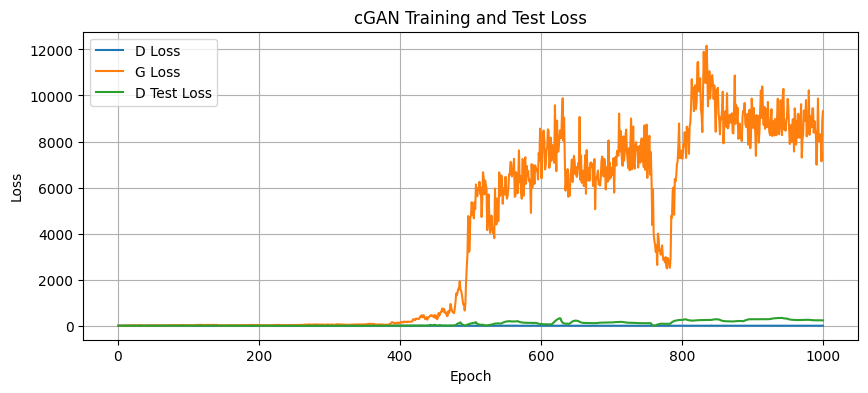

In [0]:

# Plot the loss.
fig, ax = plt.subplots(figsize=(10, 4))
loss_df.plot(ax=ax)
plt.title('cGAN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['D Loss', 'G Loss', 'D Test Loss'])
plt.grid(True)

# Make sure to use a correct path to save the plot.
plot_path =  "/dbfs/FileStore/m332479/GANs_forCyberSecurity/plots/loss_plot.png"
plt.savefig(plot_path)

# Log the plot artifact in MLflow.
mlflow.log_artifact(plot_path)



### Training Performance Challenges

When training a Generative Adversarial Network (GAN), observing the discriminator loss (D loss) and generator loss (G loss) diverging over epochs is not uncommon, but it can indicate various aspects of the training dynamics. Here are some reasons why this might happen and what they signify:

1. Imbalance in Learning Rates
If the learning rates for the discriminator and the generator are not well balanced, one might learn faster than the other. For example, if the discriminator learns too quickly, it may become too good at distinguishing real from fake images, causing its loss to decrease rapidly, while the generator's loss, which tries to fool the discriminator, increases because it cannot keep up.

2. Model Capacity
The capacity of the discriminator and generator (i.e., their ability to model complex functions) might be imbalanced. If the discriminator is significantly more powerful than the generator, it will easily identify the fake samples, leading to a divergence in losses where the discriminator's loss goes down (it's winning easily) while the generator's loss goes up (it's unable to fool the discriminator).

3. Overfitting
The discriminator might be overfitting to the training data. This means it becomes very good at distinguishing the real training samples from the fakes but might not generalize well to unseen data. In such cases, its loss may decrease because it's performing well on the training set, while the generator's loss increases as it struggles to generate samples that can fool the discriminator.

4. Mode Collapse
In mode collapse, the generator starts producing a limited variety of outputs. While these outputs may initially fool the discriminator, over time, the discriminator learns to identify these repetitive outputs as fake. This leads to the generator's loss increasing as it fails to produce diverse enough samples to trick the discriminator.

5. Training Instability
GANs are known for their training instability. Small changes in the training setup (like batch size, architecture, or initialization) can lead to significant differences in training dynamics. Diverging losses can be a symptom of such instability, where the adversarial training process does not converge to a stable solution.

### Mitigation Strategies
1. Adjust Learning Rates: Fine-tuning the learning rates of the discriminator and generator can help balance their learning speeds.
Modify Model Architectures: Ensuring that the discriminator and generator are well-matched in capacity can prevent one from overpowering the other.
2. Regularization Techniques: Applying regularization techniques like dropout or gradient penalty can help prevent overfitting and promote more stable training.
3. Diverse Training Samples: Using techniques like minibatch discrimination or injecting noise can help prevent mode collapse by encouraging the generator to produce a more diverse set of outputs.
4. Alternative Loss Functions: Experimenting with different loss functions (e.g., Wasserstein loss) can help improve training stability and convergence behavior.


In [0]:
# After training, you can save the models and use them to generate new data or further analysis.
